## Install and Import Required Libraries

In [ ]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

### Install segment-anything

In [ ]:
#!pip install git+https://github.com/facebookresearch/segment-anything.git

### Install clip

In [ ]:
# #pip install git+https://github.com/openai/CLIP.git
# # pip install clip-by-openai 
# !pip install --upgrade git+https://github.com/openai/CLIP.git

## Downloading and Prepare Data

## Downloading Data

In [ ]:
# import gdown
# import zipfile
# import os

# # Google Drive file ID from the link
# file_id = "1hcGkpo39lp6PuinYJctipuCedJuoLxrz"
# output_file = "/home/aibek/Desktop/HASAAN_WORK/dataset.zip"  # Output file name for the downloaded zip

# # Construct the download URL
# download_url = f"https://drive.google.com/uc?id={file_id}"

# # Download the file using gdown
# print("Downloading file...")
# gdown.download(download_url, output_file, quiet=False)

# # Unzipping the file
# if os.path.exists(output_file):
#     print("Unzipping file...")
#     with zipfile.ZipFile(output_file, 'r') as zip_ref:
#         zip_ref.extractall("extracted_data")  # Extract to 'extracted_data' folder
#     print("Unzipping complete!")
#     os.remove(output_file)  # Optionally remove the zip file
# else:
#     print("Download failed or file not found.")


### Data loading and preview data:

Total number of images: 346
Total number of JPG mask files: 346
Total number of NPY mask files: 346


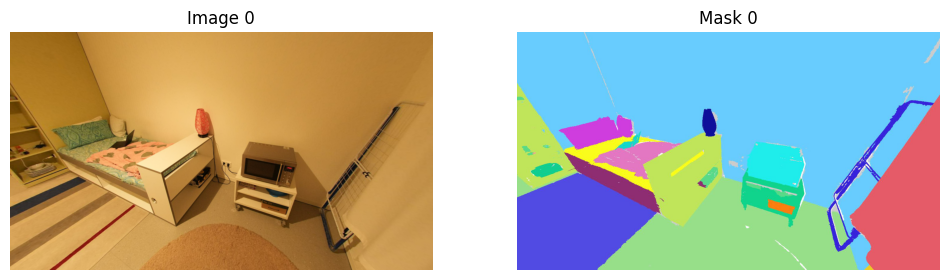

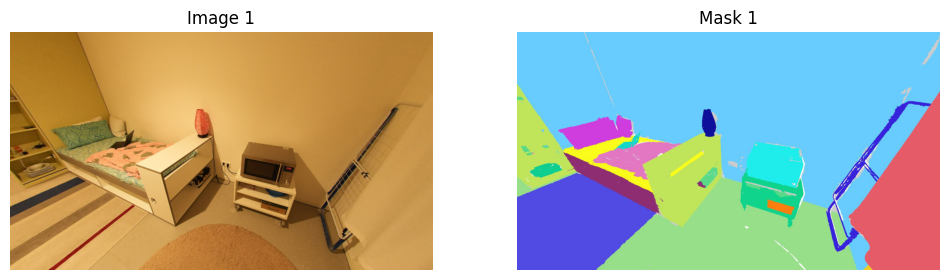

In [ ]:
import os
import numpy as np
import torch
import clip
from PIL import Image, ImageDraw
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

data_folder = "./Dataset"
images_path = os.path.join(data_folder, "images_0a7cc")
masks_jpg_path = os.path.join(data_folder, "gt_semantic_2d", "render_semantic")
masks_npy_path = os.path.join(data_folder, "gt_semantic_2d", "render_semantic_npy")

image_files = sorted([f for f in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, f))])
images = [Image.open(os.path.join(images_path, f)).convert("RGB") for f in image_files]

masks_jpg_files = sorted([f for f in os.listdir(masks_jpg_path) if os.path.isfile(os.path.join(masks_jpg_path, f))])
masks_npy_files = sorted([f for f in os.listdir(masks_npy_path) if os.path.isfile(os.path.join(masks_npy_path, f))])

masks_jpg = [Image.open(os.path.join(masks_jpg_path, f)) for f in masks_jpg_files]
masks_npy = [np.load(os.path.join(masks_npy_path, f)) for f in masks_npy_files]

print(f"Total number of images: {len(images)}")
print(f"Total number of JPG mask files: {len(masks_jpg)}")
print(f"Total number of NPY mask files: {len(masks_npy)}")

def display_sample(image, mask, index):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title(f"Image {index}")
    ax[0].axis('off')
    
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title(f"Mask {index}")
    ax[1].axis('off')
    
    plt.show()

for i in range(2):
    display_sample(images[i], masks_jpg[i], i)

#### Check the shapes of images, JPG masks, and NPY masks

In [2]:
# Check the shapes of images, JPG masks, and NPY masks

# Check shapes of images (should be in RGB format, e.g., (H, W, 3))
print("\nImage Shapes:")
for i, image in enumerate(images[:3]):  # Checking first 3 images
    print(f"Image {i} shape: {image.size} (Width x Height)")

# Check shapes of JPG masks (should be 2D, e.g., (H, W))
print("\nJPG Mask Shapes:")
for i, mask in enumerate(masks_jpg[:3]):  # Checking first 3 JPG masks
    print(f"Mask {i} shape: {mask.size} (Width x Height)")

# Check shapes of NPY masks (should be 2D, e.g., (H, W))
print("\nNPY Mask Shapes:")
for i, mask in enumerate(masks_npy[:3]):  # Checking first 3 NPY masks
    print(f"Mask {i} shape: {masks_npy[i].shape} (Height x Width)")




Image Shapes:
Image 0 shape: (1440, 811) (Width x Height)
Image 1 shape: (1440, 811) (Width x Height)
Image 2 shape: (1440, 811) (Width x Height)

JPG Mask Shapes:
Mask 0 shape: (1440, 811) (Width x Height)
Mask 1 shape: (1440, 811) (Width x Height)
Mask 2 shape: (1440, 811) (Width x Height)

NPY Mask Shapes:
Mask 0 shape: (811, 1440) (Height x Width)
Mask 1 shape: (811, 1440) (Height x Width)
Mask 2 shape: (811, 1440) (Height x Width)


In [3]:
# Count total files in each folder
total_images = len([f for f in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, f))])
total_masks_jpg = len([f for f in os.listdir(masks_jpg_path) if os.path.isfile(os.path.join(masks_jpg_path, f))])
total_masks_npy = len([f for f in os.listdir(masks_npy_path) if os.path.isfile(os.path.join(masks_npy_path, f))])

# Print counts
print(f"Total number of image files: {total_images}")
print(f"Total number of JPG mask files: {total_masks_jpg}")
print(f"Total number of NPY mask files: {total_masks_npy}")


Total number of image files: 346
Total number of JPG mask files: 346
Total number of NPY mask files: 346


In [ ]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Is CUDA available?", torch.cuda.is_available())
print("Number of GPUs available:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

PyTorch version: 2.0.0
CUDA version: 11.7
Is CUDA available? True
Number of GPUs available: 1
Current GPU: NVIDIA A100-SXM4-80GB


## Load models

In [ ]:
# Initialize parameters
sam_checkpoint = "./checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"  

print("Loading SAM model...")
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
print("SAM model loaded successfully.")

# Initialize SAM Automatic Mask Generator
mask_generator = SamAutomaticMaskGenerator(sam)

# Load the CLIP model
print("Loading CLIP model...")
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()  # Set CLIP to evaluation mode
print("CLIP model loaded successfully.")

Loading SAM model...
SAM model loaded successfully.
Loading CLIP model...
CLIP model loaded successfully.


###  Define the textual prompt

In [6]:
# Define the textual prompt and corresponding ground truth class
text_prompt = "chair"
gt_class = 8 

# Encode the text prompt
with torch.no_grad():
    text_tokens = clip.tokenize([text_prompt]).to(device)
    text_embedding = clip_model.encode_text(text_tokens)
    text_embedding /= text_embedding.norm(dim=-1, keepdim=True)  
print(f"Encoded text prompt: '{text_prompt}'.")


Encoded text prompt: 'chair'.


In [7]:
def compute_iou(mask1, mask2):
    """
    Computes the Intersection over Union (IoU) of two binary masks.
    
    Args:
        mask1 (np.ndarray): First binary mask.
        mask2 (np.ndarray): Second binary mask.
        
    Returns:
        float: IoU score.
    """
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        # If both masks are empty, assume IoU = 1.0
        if mask1.sum() == 0 and mask2.sum() == 0:
            return 1.0
        else:
            return 0.0
    else:
        return intersection / union


In [ ]:
def visualize_results(image, gt_mask, predicted_mask, idx):
    """
    Visualizes the original image, ground truth mask, predicted mask, and overlay.
    
    Args:
        image (PIL.Image): Original image.
        gt_mask (np.ndarray): Ground truth binary mask.
        predicted_mask (np.ndarray): Predicted binary mask.
        idx (int): Image index.
    """
    # Prepare ground truth mask as PIL Image
    gt_mask_pil = Image.fromarray((gt_mask * 255).astype(np.uint8))
    
    # Prepare predicted mask as PIL Image
    predicted_mask_pil = Image.fromarray((predicted_mask * 255).astype(np.uint8))
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original Image
    axs[0].imshow(image)
    axs[0].set_title(f"Original Image (Index {idx})")
    axs[0].axis('off')
    
    # Ground Truth Mask
    axs[1].imshow(gt_mask, cmap='gray')
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis('off')
    
    # Predicted Mask
    axs[2].imshow(predicted_mask, cmap='gray')
    axs[2].set_title("Predicted Mask")
    axs[2].axis('off')
    
    # Overlay Predicted Mask on Image
    overlay = image.copy().convert("RGBA")
    mask_overlay = Image.new("RGBA", image.size, (255, 0, 0, 0))  
    mask_overlay_pixels = mask_overlay.load()

    # Convert predicted_mask to a NumPy array for efficient processing
    predicted_mask_np = np.array(predicted_mask)
    height, width = predicted_mask_np.shape

    # Apply red color to mask pixels
    for y in range(height):
        for x in range(width):
            if predicted_mask_np[y, x]:
                mask_overlay_pixels[x, y] = (255, 0, 0, 100) 

    # Composite the overlay
    overlay = Image.alpha_composite(overlay, mask_overlay)
    axs[3].imshow(overlay)
    axs[3].set_title("Overlay: Predicted Mask")
    axs[3].axis('off')
    
    plt.show()


In [ ]:
# Initialize list to store IoU scores
iou_scores = []

# Initialize list to store data for visualization
visualization_data = []

# Select every 10th image to reduce computational requirements
selected_indices = range(0, len(images), 10)
print(f"Processing {len(selected_indices)} images out of {len(images)}...")

for idx in tqdm(selected_indices, desc="Processing Images"):
    image = images[idx]
    gt_mask_npy = masks_npy[idx]  

    # Convert PIL Image to NumPy array
    image_np = np.array(image)

    # Generate masks using SAM's automatic mask generator
    try:
        masks = mask_generator.generate(image_np)
    except Exception as e:
        print(f"Error generating masks for image {idx}: {e}")
        masks = []

    # Get ground truth mask for the class "chair" (class 8)
    gt_mask = (gt_mask_npy == gt_class)

    if len(masks) == 0:
        # If no masks are generated
        if gt_mask.sum() == 0:
            # Both prediction and ground truth have no objects
            iou_scores.append(1.0)
        else:
            # Ground truth has objects, but prediction has none
            iou_scores.append(0.0)
        continue

    # Prepare to batch process masks for efficiency
    cropped_images = []
    mask_indices = []

    for mask_idx, mask_dict in enumerate(masks):
        # Get the binary mask
        mask = mask_dict['segmentation']  

        # Check if the mask has any pixels
        if mask.sum() == 0:
            continue  

        # Find bounding box of the mask
        ys, xs = np.where(mask)
        if len(ys) == 0 or len(xs) == 0:
            continue  

        min_y, max_y = ys.min(), ys.max()
        min_x, max_x = xs.min(), xs.max()

        # Crop the image to the bounding box
        cropped_image = image.crop((min_x, min_y, max_x + 1, max_y + 1))

        # Apply the mask to the cropped image
        mask_cropped = mask[min_y:max_y + 1, min_x:max_x + 1]
        mask_pil = Image.fromarray((mask_cropped * 255).astype(np.uint8))
        cropped_image.putalpha(mask_pil)

        # Convert to RGB (since CLIP expects RGB images)
        cropped_image_rgb = cropped_image.convert("RGB")

        # Preprocess the cropped image for CLIP
        cropped_image_input = preprocess(cropped_image_rgb).unsqueeze(0).to(device)
        cropped_images.append(cropped_image_input)
        mask_indices.append(mask_idx)

    if len(cropped_images) == 0:
        # No valid masks to process
        if gt_mask.sum() == 0:
            # Both prediction and ground truth have no objects
            iou_scores.append(1.0)
        else:
            # Ground truth has objects, but prediction has none
            iou_scores.append(0.0)
        continue

    # Stack all cropped images into a single batch
    batch_input = torch.cat(cropped_images, dim=0) 

    with torch.no_grad():
        # Encode all cropped images
        image_embeddings = clip_model.encode_image(batch_input)
        image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True) 

    # Compute cosine similarities between image embeddings and text embedding
    similarities = (image_embeddings @ text_embedding.T).squeeze(-1)  

    # Define a similarity threshold
    similarity_threshold = 0.28

    # Select masks with similarity above the threshold
    selected_mask_indices = [i for i, sim in enumerate(similarities) if sim >= similarity_threshold]

    if len(selected_mask_indices) == 0:
        # If no matching masks found
        if gt_mask.sum() == 0:
            # Both prediction and ground truth have no objects
            iou_scores.append(1.0)
        else:
            # Ground truth has objects, but prediction has none
            iou_scores.append(0.0)
        continue

    # Combine all matching masks using logical OR
    combined_mask = np.zeros_like(masks[0]['segmentation'], dtype=bool)
    for i in selected_mask_indices:
        combined_mask = np.logical_or(combined_mask, masks[mask_indices[i]]['segmentation'])

    # Compute IoU
    iou = compute_iou(combined_mask, gt_mask)
    iou_scores.append(iou)

    # Store data for visualization
    visualization_data.append({
        'idx': idx,
        'image': image,
        'gt_mask': gt_mask,
        'predicted_mask': combined_mask
    })

Processing 35 images out of 346...


Processing Images:   0%|          | 0/35 [00:00<?, ?it/s]

## Visualization of all matching images

Visualizing Results:   0%|          | 0/10 [00:00<?, ?it/s]

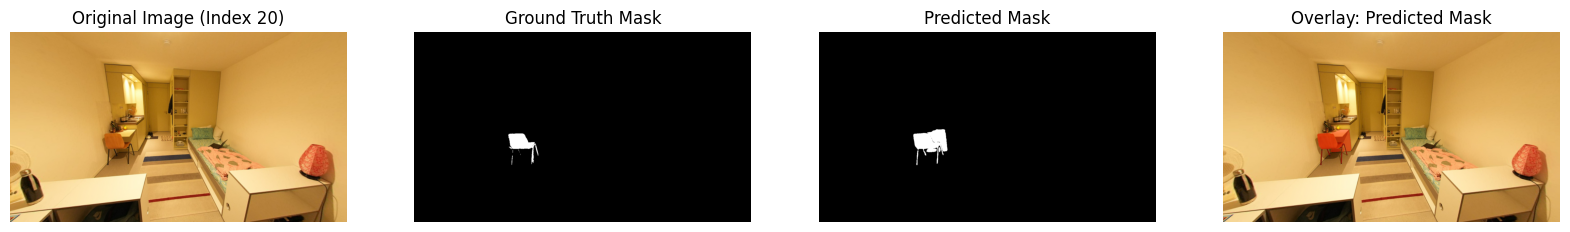

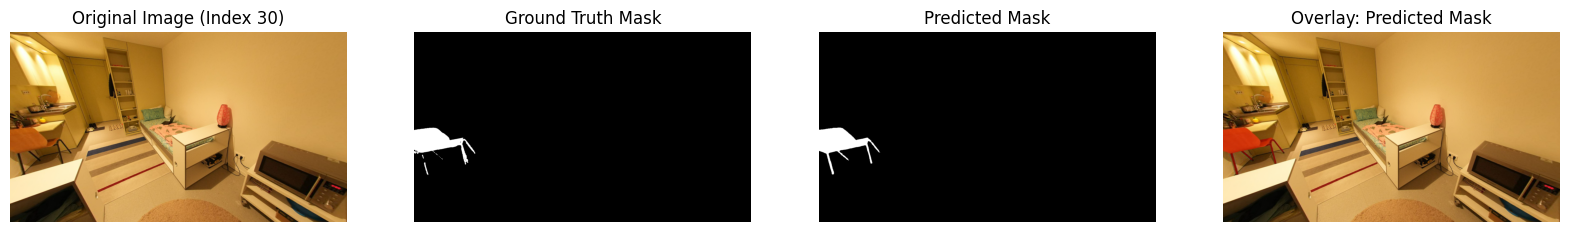

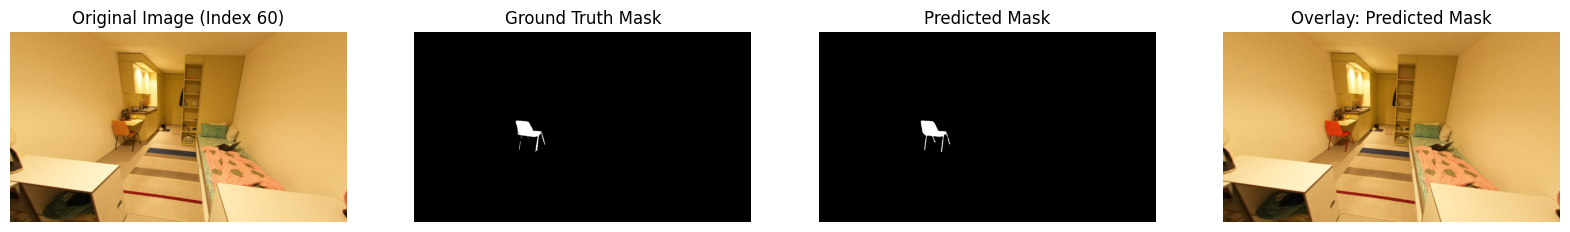

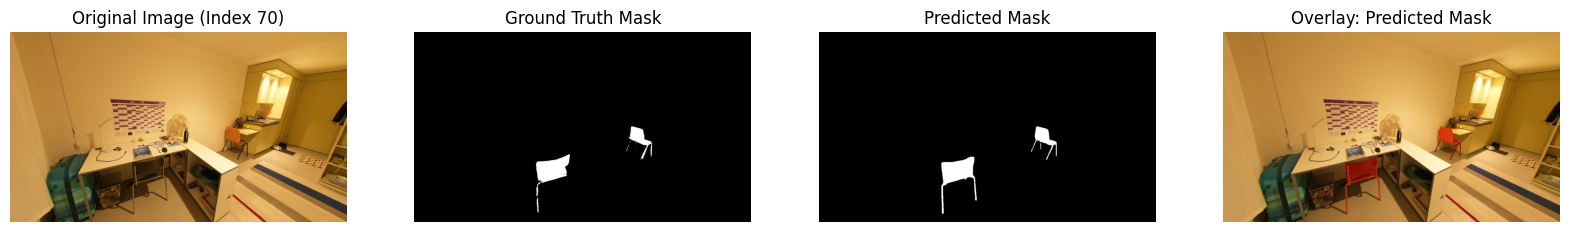

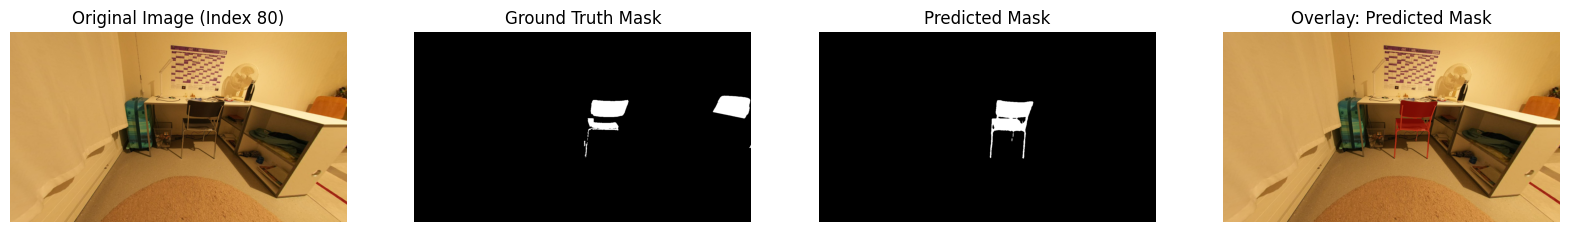

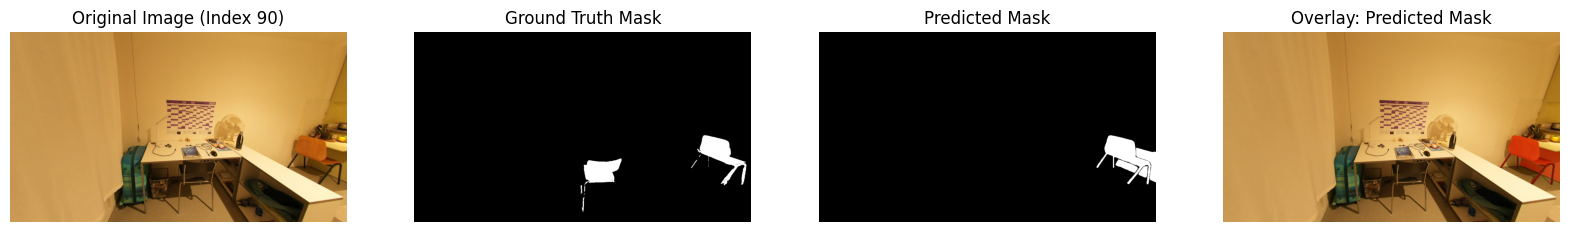

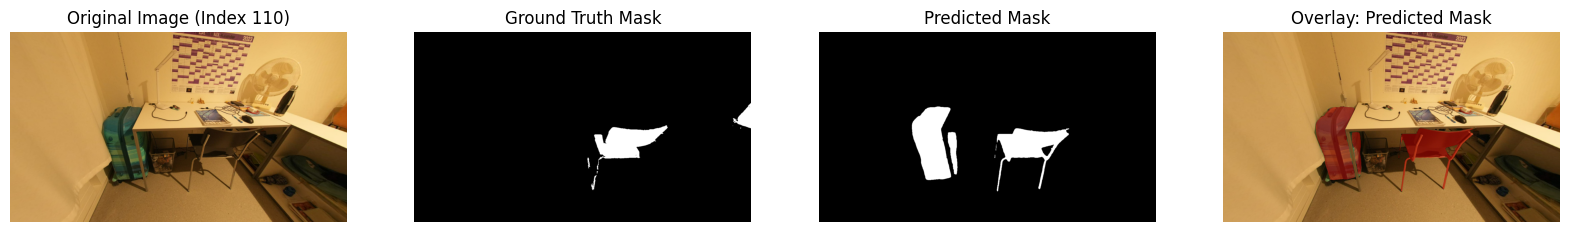

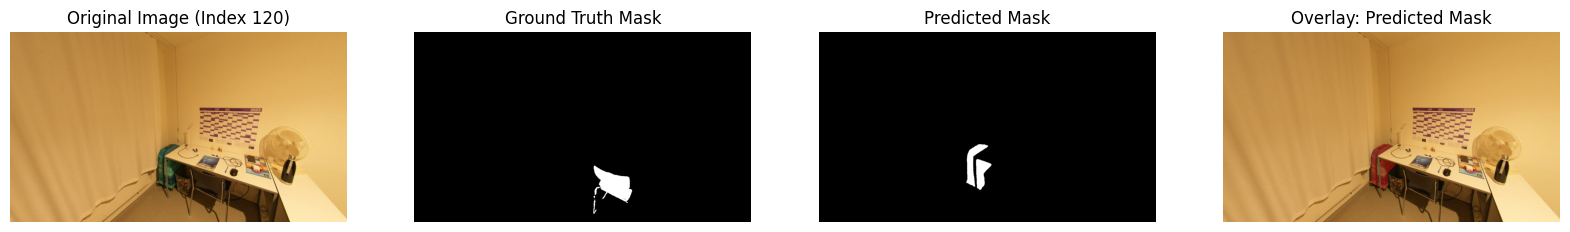

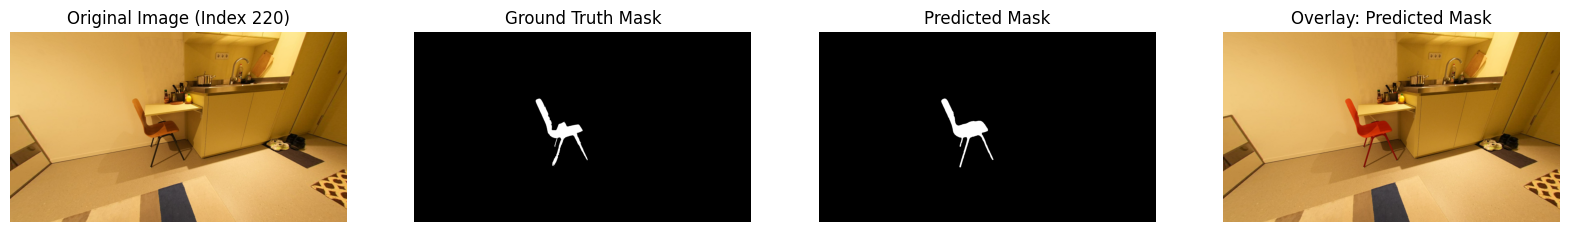

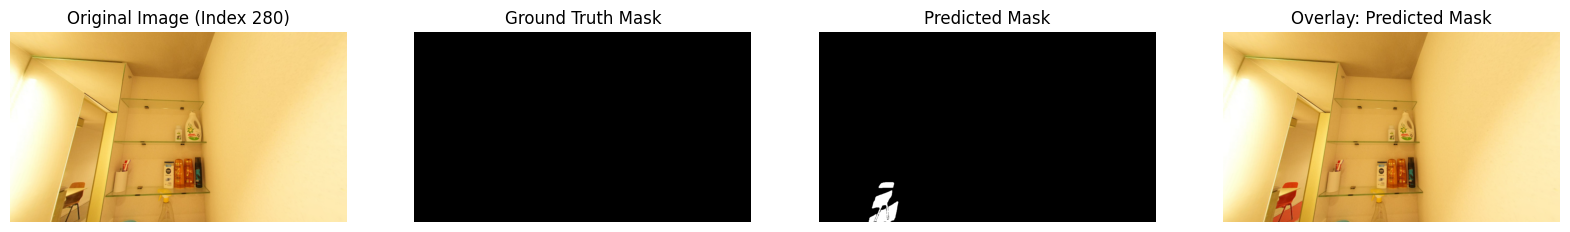

In [ ]:
# Visualization of all matching images
if visualization_data:
    for data in tqdm(visualization_data, desc="Visualizing Results"):
        idx = data['idx']
        image = data['image']
        gt_mask = data['gt_mask']
        predicted_mask = data['predicted_mask']
        
        visualize_results(image, gt_mask, predicted_mask, idx)
else:
    print("No matching masks found to visualize.")

In [21]:
# Compute mean IoU
mean_iou = np.mean(iou_scores)
print(f"\nMean IoU for class '{text_prompt}': {mean_iou:.4f}")

# Print all IoU scores
print("\nIndividual IoU scores:")
for idx, iou in zip(selected_indices, iou_scores):
    print(f"Image {idx}: IoU = {iou:.4f}")



Mean IoU for class 'chair': 0.6824

Individual IoU scores:
Image 0: IoU = 1.0000
Image 10: IoU = 1.0000
Image 20: IoU = 0.5083
Image 30: IoU = 0.8842
Image 40: IoU = 1.0000
Image 50: IoU = 1.0000
Image 60: IoU = 0.8677
Image 70: IoU = 0.8248
Image 80: IoU = 0.4362
Image 90: IoU = 0.3799
Image 100: IoU = 0.0000
Image 110: IoU = 0.3102
Image 120: IoU = 0.0000
Image 130: IoU = 0.0000
Image 140: IoU = 1.0000
Image 150: IoU = 0.0000
Image 160: IoU = 0.0000
Image 170: IoU = 0.0000
Image 180: IoU = 1.0000
Image 190: IoU = 1.0000
Image 200: IoU = 1.0000
Image 210: IoU = 0.0000
Image 220: IoU = 0.6741
Image 230: IoU = 1.0000
Image 240: IoU = 1.0000
Image 250: IoU = 1.0000
Image 260: IoU = 1.0000
Image 270: IoU = 1.0000
Image 280: IoU = 0.0000
Image 290: IoU = 1.0000
Image 300: IoU = 1.0000
Image 310: IoU = 1.0000
Image 320: IoU = 1.0000
Image 330: IoU = 1.0000
Image 340: IoU = 1.0000
